In [1]:
# uncomment describe in question 1
#1.4 what does it mean to report the accuracy???
# finish 1.3 normalization 
# 1.4???

#2.3 answer
# 2.4 update interpretation and also provide more info for text answer based on model accuracies???

#3.1 put in accuracy values and add text ans
#3.2 bootstrapping?? and rest of question 3

#4.2 should we stratify by cancer type?? why did I have to cast as an int?? should measurements be normalized?


# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- **This is an individual homework. No group collaboration.**
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [3]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw4.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.


**1.3** Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.

Plot two histograms ofyour best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.

Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.


**1.4** Using your top gene from the previous part (call it  `best_predictor`), create a classification model by manually eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.

<hr> <hr>

<hr>
### Solutions

**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [64]:
# Split data into 80-20 train-test split
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)


X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [65]:
# Print shape of data before splitting
print('Shape before splitting:', df.shape)
# Print shape of data after splitting
print('\nTraining predictor data after splitting:', X_train.shape, '\nTesting predictor data after splitting:', X_test.shape, '\nResponse training data after splitting:', y_train.shape, '\nResponse testing data after splitting:', y_test.shape)
print('\nProportion of ALL cases (0) vs. AML cases (1) across all data:\n',df.Cancer_type.value_counts(normalize=True))


Shape before splitting: (752, 7130)

Training predictor data after splitting: (601, 7129) 
Testing predictor data after splitting: (151, 7129) 
Response training data after splitting: (601,) 
Response testing data after splitting: (151,)

Proportion of ALL cases (0) vs. AML cases (1) across all data:
 0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.**


In [66]:
# Check predictor gene values before normalization
print('\nInspect gene names:\n', X_train.columns) # Confirm that the columns are gene names
print('\nInspect first few genes:\n', X_train.head()) # Overall there is much variability in the measurements of each gene even just in the first 5 measurements
print('\nInspect predictor summary statistics:\n', X_train.describe()) # The mean measurement value for each gene varies considerably, as does the minimum and maximum values 
print('\nOverall mean:\n', X_train.stack().mean())
print('\nOverall standard deviation:\n', X_train.stack().std()) # Standard deviation of measurements across all genes is much higher than the mean overall



Inspect gene names:
 Index(['AFFX-BioB-5_at', 'AFFX-BioB-M_at', 'AFFX-BioB-3_at', 'AFFX-BioC-5_at',
       'AFFX-BioC-3_at', 'AFFX-BioDn-5_at', 'AFFX-BioDn-3_at',
       'AFFX-CreX-5_at', 'AFFX-CreX-3_at', 'AFFX-BioB-5_st',
       ...
       'U48730_at', 'U58516_at', 'U73738_at', 'X06956_at', 'X16699_at',
       'X83863_at', 'Z17240_at', 'L49218_f_at', 'M71243_f_at', 'Z78285_f_at'],
      dtype='object', length=7129)

Inspect first few genes:
      AFFX-BioB-5_at  AFFX-BioB-M_at  AFFX-BioB-3_at  AFFX-BioC-5_at  \
486      -83.669345     -129.202197       91.188553     -132.634919   
604      -65.718571     -302.842019     -297.819728     -177.485917   
341     -264.191248     -162.255274      127.997172      173.771779   
117      -92.558574     -109.788332      379.542547      391.641129   
516     -143.099813      140.202023     -147.163850      222.339115   

     AFFX-BioC-3_at  AFFX-BioDn-5_at  AFFX-BioDn-3_at  AFFX-CreX-5_at  \
486     -416.659258      -566.248620      -549.2552

In [67]:
# Normalize values of each predictor
#x_reshaped = np.array(X_train).reshape(-1,1) # reshape in order to pass data into MinMaxScaler for normalization
#X_train_scaled = MinMaxScaler().fit_transform(x_reshaped)
#X_train = pd.DataFrame(X_train_scaled.reshape(len(X_train),len(X_train.columns)),columns=X_train.columns) # convert X_train from an numpy.ndarray back into a dataframe 
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

In [68]:
# Check predictor gene values after normalization
print('\nInspect gene names:\n', X_train_scaled.columns) # Confirm that the columns are gene names
print('\nInspect first few genes:\n', X_train_scaled.head()) # Overall there is less variability in the measurements of each gene even just in the first 5 measurements
print('\nInspect predictor summary statistics:\n', X_train_scaled.describe()) # The mean measurement value for each gene does not vary considerably; max and min values are 1 and 0, respectively
print('\nOverall mean:\n', X_train_scaled.stack().mean())
print('\nOverall standard deviation:\n', X_train_scaled.stack().std()) # Standard deviation of measurements across all genes is not much higher than the mean overall



Inspect gene names:
 Index(['AFFX-BioB-5_at', 'AFFX-BioB-M_at', 'AFFX-BioB-3_at', 'AFFX-BioC-5_at',
       'AFFX-BioC-3_at', 'AFFX-BioDn-5_at', 'AFFX-BioDn-3_at',
       'AFFX-CreX-5_at', 'AFFX-CreX-3_at', 'AFFX-BioB-5_st',
       ...
       'U48730_at', 'U58516_at', 'U73738_at', 'X06956_at', 'X16699_at',
       'X83863_at', 'Z17240_at', 'L49218_f_at', 'M71243_f_at', 'Z78285_f_at'],
      dtype='object', length=7129)

Inspect first few genes:
    AFFX-BioB-5_at  AFFX-BioB-M_at  AFFX-BioB-3_at  AFFX-BioC-5_at  \
0        0.574689        0.652904        0.528552        0.202384   
1        0.587407        0.535608        0.249427        0.171417   
2        0.446787        0.630576        0.554963        0.413946   
3        0.568391        0.666018        0.735454        0.564376   
4        0.532581        0.834889        0.357527        0.447480   

   AFFX-BioC-3_at  AFFX-BioDn-5_at  AFFX-BioDn-3_at  AFFX-CreX-5_at  \
0        0.504132         0.309107         0.439480        0.5244

In [121]:
# Also normalize predictors in the testing data
# should it be X_test in the fit_transform or should it be X_train here? Want to normalize according to the training data

#X_test_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df.loc[:, df.columns != 'Cancer_type']), columns=X_test.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [122]:
# Check that normalizing was successful (max should be 1 and min 0 for each predictor)
X_test_scaled.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,...,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.558739,0.628584,0.483741,0.433760,0.611364,0.372105,0.575820,0.523991,0.631786,0.517030,...,0.556287,0.508939,0.464691,0.392301,0.604984,0.531941,0.394276,0.515471,0.515281,0.454457
std,0.122118,0.138197,0.147509,0.134576,0.141210,0.138466,0.140544,0.152170,0.114369,0.146962,...,0.121811,0.150016,0.152998,0.105910,0.150592,0.129336,0.136484,0.145916,0.150673,0.135950
min,0.222337,0.052362,0.124898,0.105928,0.071105,0.050836,0.156020,0.039091,0.320783,0.206945,...,0.201957,0.070354,0.172558,0.181925,0.141525,0.149185,0.120792,0.140083,0.166168,0.054844
25%,0.499868,0.548335,0.388016,0.345367,0.521641,0.273796,0.489531,0.422420,0.560308,0.435264,...,0.484829,0.403865,0.355955,0.334083,0.513409,0.455015,0.306536,0.418288,0.426565,0.368567
50%,0.560659,0.642539,0.460060,0.434223,0.627556,0.361920,0.573224,0.539889,0.625199,0.505667,...,0.558503,0.486221,0.469452,0.383539,0.599456,0.523538,0.375118,0.521046,0.502907,0.449302
75%,0.637131,0.711483,0.581579,0.522510,0.689237,0.469692,0.647892,0.634494,0.713072,0.592525,...,0.628399,0.610960,0.562807,0.426880,0.707865,0.613968,0.486736,0.620235,0.601599,0.521765
max,0.866908,0.890931,0.962346,0.809448,1.083614,0.707036,0.935497,0.920072,0.948824,1.135258,...,0.904706,0.956029,0.930731,0.837301,0.964234,0.856707,0.771090,0.860715,1.030505,0.867071


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.**

If there are more predictors than observations, the ????????????????????????????????

**1.3** **Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.**

**Plot two histograms of your best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.**

**Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.**

In [71]:
# Check whether there is a significant difference in measurement value for each gene individually between ALL and AML cases using training data and visualize the dicriminatory effect of the most differential gene in the testing set as well

ALL_y_train = y_train[y_train == 0].index
AML_y_train = y_train[y_train == 1].index
t_stat_list = []

for column in X_train_scaled.columns:
        ALL_group = X_train_scaled[column][ALL_y_train]
        AML_group = X_train_scaled[column][AML_y_train]
        numerator = np.abs(ALL_group.mean() - AML_group.mean())
        ALL_sd = ALL_group.std()
        AML_sd = AML_group.std()
        denom = np.sqrt((ALL_sd**2)/len(ALL_group) + (AML_sd**2)/len(AML_group))
        t_stat = numerator/denom
        t_stat_list.append(t_stat)       

//anaconda3/envs/cs109a/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [72]:
# Show t statistics assessing difference in measurement values between ALL and AML cases for every gene as a dataframe
d = {'gene': X_train_scaled.columns, 't_stat': t_stat_list}
gene_t_stats = pd.DataFrame(d)

In [73]:
gene_t_stats['t_stat'].max()

4.933805910802824

In [74]:
gene_t_stats.loc[gene_t_stats['gene'] == 'D26067_at']

,gene,t_stat
306,D26067_at,4.933806


In [75]:
# Find top 10 most differential genes

# Find index values for top 10 t statistics (already these are all positive because the absolute value was taken when calculating t statistic)
top_10_index = np.argsort(t_stat_list)[-10:]
print('Top 10 most differential genes:\n', list(X_train_scaled.iloc[:,top_10_index].columns))

top_1_index = np.argsort(t_stat_list)[-1:]
print('Best predictor gene:\n', list(X_train_scaled.iloc[:,top_1_index].columns))

Top 10 most differential genes:
 ['U56085_at', 'M17446_s_at', 'Z46632_r_at', 'U83411_at', 'J00220_cds4_at', 'M81650_rna1_at', 'J05401_at', 'L13744_at', 'X87160_at', 'D26067_at']
Best predictor gene:
 ['D26067_at']


In [96]:
# Confirm that gene with max t statistic 
gene_t_stats.loc[gene_t_stats['t_stat'] == gene_t_stats['t_stat'].max()]['gene']

306    D26067_at
Name: gene, dtype: object

//anaconda3/envs/cs109a/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
//anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


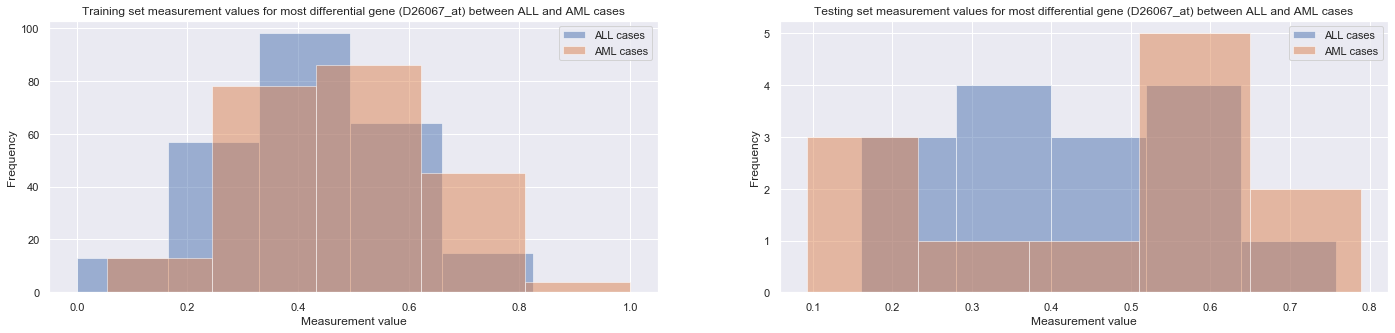

In [139]:
# Find ALL and AML cases in test data
ALL_y_test = y_test[y_test == 0].index
AML_y_test = y_test[y_test == 1].index

# Make histograms of measurement value for best predictor gene in order to observe that measurements differ between ALL and AML cases
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,5))
ax = ax.ravel()

ax[0].hist(X_train_scaled.loc[ALL_y_train,list(X_train_scaled.iloc[:,top_1_index].columns)].values, alpha = 0.5, bins=5, label="ALL cases"); # Data for ALL cases
ax[0].hist(X_train_scaled.loc[AML_y_train,list(X_train_scaled.iloc[:,top_1_index].columns)].values, alpha = 0.5, bins=5, label="AML cases"); # Data for AML cases
ax[0].set_title('Training set measurement values for most differential gene ({}) between ALL and AML cases'.format(X_train_scaled.iloc[:,top_1_index].columns[0]))
ax[0].set_xlabel('Measurement value');
ax[0].set_ylabel('Frequency');
ax[0].legend();

ax[1].hist(X_test_scaled.loc[ALL_y_test,list(X_test_scaled.iloc[:,top_1_index].columns)].values, alpha = 0.5, bins=5, label="ALL cases"); # Data for ALL cases
ax[1].hist(X_test_scaled.loc[AML_y_test,list(X_test_scaled.iloc[:,top_1_index].columns)].values, alpha = 0.5, bins=5, label="AML cases"); # Data for AML cases
ax[1].set_title('Testing set measurement values for most differential gene ({}) between ALL and AML cases'.format(X_test_scaled.iloc[:,top_1_index].columns[0]))
ax[1].set_xlabel('Measurement value');
ax[1].set_ylabel('Frequency');
ax[1].legend();


**1.4 Using your top gene from the previous part (call it  `best_predictor`), create a classification model by eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.**


In [98]:
# Choose best predictor 

best_predictor = gene_t_stats.loc[gene_t_stats['t_stat'] == gene_t_stats['t_stat'].max()]['gene']
print(best_predictor)

306    D26067_at
Name: gene, dtype: object


In order to discriminate between the two classes, I would choose 0.5 as the cutoff (normalized) measurement value such that patients with normalized measurement values >0.5 for this best_predictor gene would be classified as an ALL case and patients with normalized measurement values <=0.5 for this best_predictor gene would be classified as an AML case. This split is based on the training set data (since the peaks of the orange and blue histograms in the left panel occur on opposite sides of the line x = 0.5) and has an accuracy of 0.43 on the test set (as calculated below). 

In [140]:
# Accuracy of model is proportion of correct predictions

# Proportion of correct AML cases (1s)
accuracy_score(y_test, np.round(X_test_scaled.loc[:,list(X_test_scaled.iloc[:,top_1_index].columns)].values))


# Proportion of correct ALL cases (0s)

0.4304635761589404

<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>


In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor that you identify as the best predictor above to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML). Is there a problem with this interpretation?


Create a figure with following items displayed on the same plot (use training data):
 - the predicted quantitative response from the linear regression model as a function of the best gene predictor
 - the true binary response. 


**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.


**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 


**2.4** 
Print and interpret the logistic regression coefficients: the 'slope' and intercept. 


Create 2 plots (one each for training and testing data) with 4 items displayed on each plot.
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



<hr>
### Solutions

**2.1** **Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML).  Is there a problem with this interpretation?**



In [76]:
X_train_scaled_reshape = np.array(X_train_scaled.iloc[:,top_1_index]).reshape(X_train_scaled.iloc[:,top_1_index].shape[0], 1)
y_train.shape, X_train_scaled_reshape.shape

((601,), (601, 1))

In [159]:
X_test_scaled_reshape = np.array(X_test_scaled.iloc[:,top_1_index]).reshape(X_test_scaled.iloc[:,top_1_index].shape[0], 1)
y_test.shape, X_test_scaled_reshape.shape

((151,), (151, 1))

In [160]:
#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X_train_scaled_reshape, y_train)

predicted_y = regression.predict(X_test_scaled_reshape)

r2 = regression.score(X_test_scaled_reshape, y_test)
print(f'R^2 = {r2:.5}')

R^2 = 0.055611


The predicted response score for a patient from the regression model should be interpretated as the amount of increase in the probability that the patient has AML relative to ALL for every one unit increase in the best_predictor gene's normalized measurement value. This model does not model the response variable well (having AML vs. ALL) because the response is binary while the linear regression model predicts a continuous response variable given the predictors. 

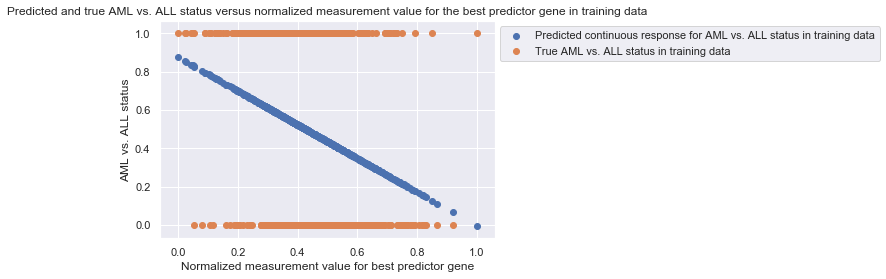

In [171]:
# Plot the predicted continuous response versus the normalized measurement value for the best predictor gene
# Plot the true response (AML vs. ALL) versus the normalized measurement value for the best predictor gene
predicted_y_train = regression.predict(X_train_scaled_reshape)

ax = plt.subplot(111)
plt.scatter(X_train_scaled_reshape, predicted_y_train, label = 'Predicted quantiative response from linear regression for AML vs. ALL status in training data')
plt.scatter(X_train_scaled_reshape, y_train, label = 'True AML vs. ALL status in training data')
plt.xlabel('Normalized measurement value for best predictor gene')
plt.ylabel('AML (1) vs. ALL (0) status')
plt.title('Predicted and true AML vs. ALL status versus normalized measurement value for the best predictor gene in training data')

ax.legend(bbox_to_anchor=(1, 1))

**2.2** **Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.**

In [191]:
# Standard Bayes' classifier is the process of classifying observations with P_hat(Y=1) >= 0.5 to be in the group associated with Y=1 and all observations with P_hat(Y=0) < 0.5 to be in the group associated with Y=0

predicted_y_train_BayesClass = np.round(predicted_y_train)

predicted_y_test = regression.predict(X_test_scaled_reshape)
predicted_y_test_BayesClass = np.round(predicted_y_test)

# Evaluate accuracy on training set
print('Linear regression accuracy on training set:', accuracy_score(y_train, predicted_y_train_BayesClass))

# Evaluate accuracy on testing set
print('Linear regression accuracy on testing set:', accuracy_score(y_test, predicted_y_test_BayesClass))


Linear regression accuracy on training set: 0.6206322795341098
Linear regression accuracy on testing set: 0.5894039735099338



**2.3** **Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? EXCLUDED PER ERRATA -> Are the classifications substantially different?  Explain why this is the case.**

**Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').

In [192]:
# Fit logistic regression model to training set
logreg = LogisticRegression(C=10000, fit_intercept=True)
logreg.fit(X_train_scaled_reshape, y_train)

# Predictions on training set
logreg_y_hat_train = logreg.predict(X_train_scaled_reshape)

# Predictions on testing set
logreg_y_hat_test = logreg.predict(X_test_scaled_reshape)

# Evaluate accuracy on training set
print('Logistic regression accuracy on training set:', accuracy_score(y_train, logreg_y_hat_train))

# Evaluate accuracy on testing set
print('Logistic regression accuracy on testing set:', accuracy_score(y_test, logreg_y_hat_test))


# Why does lab6 not have C=100000 and fit_intercept=True
# Should I be using X_train_scaled_reshape or X_train_scaled in lr.fit???

Logistic regression accuracy on training set: 0.6222961730449251
Logistic regression accuracy on testing set: 0.5894039735099338


//anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


*your answer here* 


**ANSWER HERE**
How do the training and test classification accuracies of this model compare with the linear regression model? Are the classifications substantially different? Explain why this is the case.

**2.4 Print and interpret the logistic regression coefficients: the 'slope' and the intercept.**

**Create 2 plots (with training and test data) with 4 items displayed on each plot.**
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$.

**Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer.** 


In [206]:
# Show coefficient estimate for the best predictor gene
print('Estimated slope (beta1):', logreg.coef_[0][0])

# Show intercept estimate
print('Estimated intercept (beta0):', logreg.intercept_[0])

Estimated slope (beta1): -3.842039608150812
Estimated intercept (beta0): 1.6349318448453276


In [205]:
# Translate log odds to odds ratios
print('Estimated odds ratio for slope:', np.exp(logreg.coef_[0][0]))
print('Estimated odds ratio for intercept:', np.exp(logreg.intercept_[0]))

Estimated odds ratio for slope: 0.021449807496922876
Estimated odds ratio for intercept: 5.129108409937205


The interpretation of the slope coefficient is: For every one unit increase in normalized measurement value for the best predictor gene, there is a predicted 3.84 fold decrease in the log odds of having AML relative to ALL. This is equivalent to saying that for every one unit increase in normalized measurement value for the best predictor gene, the predicted probability of having AML is 0.021 times as likely as having ALL (odds ratio for having AML vs. ALL = 0.021).

The interpretation of the intercept is: When the normalized measurement value for the best predictor gene is 0 (i.e., when the gene is not expressed at all), the log odds of having AML relative to ALL is 1.63. This is equivalent to saying that when the normalized measurement value for the best predictor gene is 0 (i.e., when the gene is not expressed at all), the predicted probability of having AML is 5.13 times as likely as having ALL (odds ratio for having AML vs. ALL = 5.13).

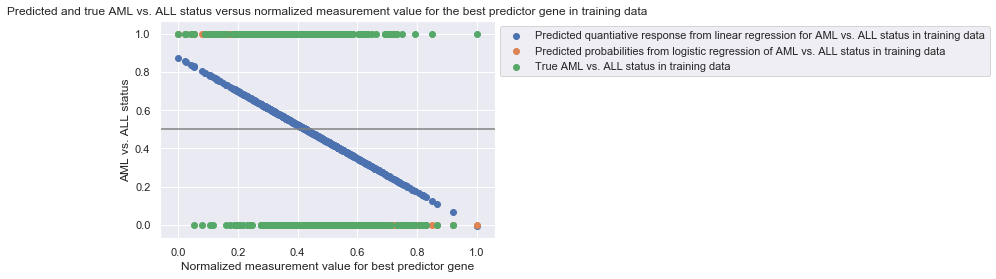

In [207]:
# Plot for training data

ax = plt.subplot(111)
plt.scatter(X_train_scaled_reshape, predicted_y_train, alpha = 0.3, label = 'Predicted quantiative response from linear regression for AML vs. ALL status in training data')
plt.scatter(X_train_scaled_reshape, logreg_y_hat_train, alpha = 0.3, label = 'Predicted probabilities from logistic regression of AML vs. ALL status in training data')
plt.scatter(X_train_scaled_reshape, y_train, alpha = 0.3, label = 'True AML vs. ALL status in training data')
plt.axhline(0.5, color="gray")
plt.xlabel('Normalized measurement value for best predictor gene')
plt.ylabel('AML (1) vs. ALL (0) status')
plt.title('Predicted and true AML vs. ALL status versus normalized measurement value for the best predictor gene in training data')

ax.legend(bbox_to_anchor=(1, 1))

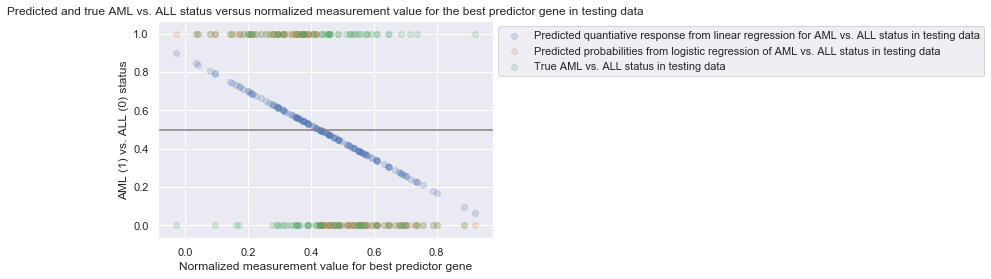

In [212]:
# Plot for testing data

ax = plt.subplot(111)
plt.scatter(X_test_scaled_reshape, predicted_y_test, alpha = 0.3, label = 'Predicted quantiative response from linear regression for AML vs. ALL status in testing data')
plt.scatter(X_test_scaled_reshape, logreg_y_hat_test, alpha = 0.3, label = 'Predicted probabilities from logistic regression of AML vs. ALL status in testing data')
plt.scatter(X_test_scaled_reshape, y_test, alpha = 0.3, label = 'True AML vs. ALL status in testing data')
plt.axhline(0.5, color="gray")
plt.xlabel('Normalized measurement value for best predictor gene')
plt.ylabel('AML (1) vs. ALL (0) status')
plt.title('Predicted and true AML vs. ALL status versus normalized measurement value for the best predictor gene in testing data')

ax.legend(bbox_to_anchor=(1, 1))

The logistic regression model appears better suited for binary classification than the linear regression model because the predicted probabilities from logistic regression of AML vs. ALL status in the testing data substantially overlap with the true AML vs. ALL status data in the plot above.

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  


**3.3** Comment on the classification accuracy of training and test set? Given the results above how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole? 

**3.4** Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.

**3.5** Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).

<hr>
### Solutions

**3.1** **Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?**  


In [213]:
# Fit multiple logistic regression

multi_logreg = LogisticRegression(C=100000, fit_intercept=True)
multi_logreg.fit(X_train_scaled, y_train)

# Predictions on training set
multi_logreg_y_hat_train = multi_logreg.predict(X_train_scaled)

# Predictions on testing set
multi_logreg_y_hat_test = multi_logreg.predict(X_test_scaled)

# Evaluate accuracy on training set
print('Multiple logistic regression accuracy on training set:', accuracy_score(y_train, multi_logreg_y_hat_train))

# Evaluate accuracy on testing set
print('Multiple logistic regression accuracy on testing set:', accuracy_score(y_test, multi_logreg_y_hat_test))

//anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Multiple logistic regression accuracy on training set: 1.0
Multiple logistic regression accuracy on testing set: 0.7748344370860927


The classification accuracies of the multiple logistic regression model using all genes as predictors using the training and testing data are higher than the accuracies obtained from both the linear regression model and logistic regression model using only the best gene as a predictor. 

**3.2** **How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.**

**Hint:** **To answer this question, use *bootstrapping* with 1000 bootstrap samples/iterations.**  


In [26]:
# your code here


In [27]:
# your code here


**3.3 Open question: Comment on the classification accuracy of training and test set? Given the results above how would you assest the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole.**

*your answer here*

**3.4 Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.**

In [28]:
# your code here


**3.5: Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).**

In [29]:
# your code here


In [30]:
# your code here


In [31]:
# your code here


In [32]:
# your code here


*your answer here* 


<div class='exercise'> <b> Question 4 [25pts]: Multi Class Log Regression </b> </div>

**4.1** Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset? 

**4.2** Split the dataset into train and test, 80-20 split, random_state = 8. 

We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using the training dataset.  It should be easily discernable via labeling/marking in the plot which observations belong to which `cancer_type`.

**4.3** Fit the following two models using crossvalidation: 
- Logistic Regression Multiclass model with linear features. 
- Logistic Regression Multiclass model with Polynomial features, degree = 2.

**4.4** Plot the decision boundaries for each model and interpret the results. Hint: You may utilize the function `overlay_decision_boundary`. 

**4.5** Report and plot the CV scores for the two models and interpret. 


<hr>
### Solutions

**4.1 Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset?**

In [6]:
# Load data from zip file

archive = zipfile.ZipFile('data/hw4_mc_enhance.csv.zip', 'r')
hw4_mc_enhance = pd.read_csv(archive.open('hw4_mc_enhance.csv'),index_col=0)

# Used https://stackoverflow.com/questions/26942476/reading-csv-zipped-files-in-python as a reference

In [80]:
# Examine the dataframe
hw4_mc_enhance.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
0,-1363.276427,-1058.585495,-541.469194,74.349803,-1110.082554,-1545.661845,-2037.029616,-1255.990888,-335.480958,-938.425691,...,1565.618803,-485.680714,-170.261227,-919.114293,1675.050053,389.769289,-526.449219,-268.963924,-779.643092,0.0
1,-796.285053,-1167.103365,7.538493,83.544731,-1116.432539,-1731.392100,249.376523,-1636.960108,-149.080421,-222.783440,...,622.498054,-1275.354673,214.828233,-750.220666,-441.589276,9.841713,-671.911209,-671.911209,-644.272577,0.0
2,-679.139168,-1069.832308,-690.301829,-112.075981,-1199.319178,-1286.387935,-605.465604,-1043.041921,-728.254877,388.011238,...,162.525483,-692.534361,517.498108,-674.674103,1265.396405,-65.192805,-714.859684,3672.066149,-822.021231,0.0
3,-1164.400197,-1109.939891,-990.127218,-238.574994,-1264.607160,-1218.860503,-1255.893511,-1009.732928,-521.768585,-926.953263,...,-31.625831,-621.975549,-458.594630,-630.689198,937.767618,-264.715941,-635.046022,475.944222,-794.070116,0.0
4,-1299.653758,-1401.998536,-1077.543813,-437.344560,-1386.755697,-1726.453259,-1499.988218,-1219.084464,-994.796971,-670.342247,...,383.591216,-905.517483,-36.675640,-1116.739685,316.087213,-210.879518,-953.423549,-291.448812,-1057.945876,0.0


In [232]:
# Examine the dataframe
hw4_mc_enhance.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,-1014.598658,-1048.357272,-823.358695,-315.636838,-1295.949886,-1625.120199,-826.955064,-1175.612555,-588.598064,-534.924646,...,812.768978,-747.263549,16.272227,-801.847334,1031.081628,-3.162310,-723.364564,-40.495922,-810.150889,1.000000
std,297.369331,233.933609,392.662256,215.534283,320.799277,419.687380,562.688520,288.546511,227.362605,489.552685,...,663.320928,176.481127,751.988770,157.068732,966.569338,495.241653,138.805059,882.681724,176.347552,0.817041
min,-2010.202020,-1772.451092,-1619.756151,-930.821077,-1984.530972,-2514.619404,-2766.759937,-1725.591441,-1255.146509,-1552.135008,...,-375.241836,-1484.465401,-853.838447,-1367.829068,-571.900054,-838.747726,-1162.232820,-1266.486530,-1298.638023,0.000000
25%,-1141.429466,-1218.887728,-1076.151552,-454.824979,-1548.108060,-1848.322368,-1203.978707,-1371.756006,-718.014815,-853.188715,...,322.566010,-847.468558,-335.783011,-924.099294,337.355440,-356.629007,-820.617263,-435.750013,-933.182073,0.000000
50%,-1033.862143,-1024.510062,-896.612263,-255.321214,-1257.060242,-1701.504007,-875.340089,-1138.486182,-586.848142,-554.578969,...,639.993676,-750.170322,-130.115409,-783.870080,777.827303,-180.519462,-733.242628,-261.276132,-816.239345,1.000000
75%,-837.607536,-885.604686,-560.246417,-196.687009,-1092.191607,-1259.153655,-508.663556,-978.433566,-416.287415,-173.861061,...,1355.814050,-654.438425,117.823076,-706.793736,1571.382500,209.283781,-609.175359,36.278669,-708.453545,2.000000
max,-385.768608,-477.363374,130.829434,257.521293,-304.800847,-850.745403,929.737460,-466.326738,196.149024,988.039921,...,2482.375600,-230.208352,5082.744968,-428.086002,4221.275650,1363.790953,-427.657222,5845.204223,-268.531949,2.000000


In [81]:
# Determine number of observations in each class (cancer type)
print('\nProportion of observations in each class across all data:\n', hw4_mc_enhance.cancer_type.value_counts(normalize=True))



Proportion of observations in each class across all data:
 2.0    0.333333
1.0    0.333333
0.0    0.333333
Name: cancer_type, dtype: float64


**4.2 Split the dataset into train and test, 80-20 split, random_state = 8.**

**We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using training dataset.  We should be able to discern from the plot which sample belongs to which `cancer_type`.** 

In [7]:
# Split data into training and testing sets

mc_X_train, mc_X_test, mc_y_train, mc_y_test = train_test_split(hw4_mc_enhance.loc[:, hw4_mc_enhance.columns != 'cancer_type'], 
                                                         hw4_mc_enhance.cancer_type, test_size=0.2, 
                                                         random_state = 8, 
                                                         stratify = hw4_mc_enhance.cancer_type)

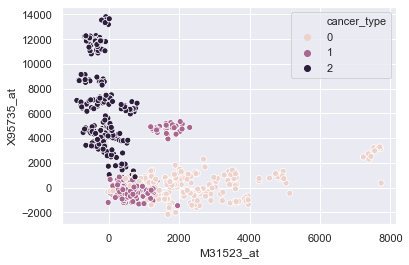

In [23]:
# Create scatter plot of two features using training data

#plt.scatter(mc_X_train['M31523_at'], mc_X_train['X95735_at'])
mc_X_train_append_mc_y_train = mc_X_train
mc_X_train_append_mc_y_train['cancer_type'] = mc_y_train.astype('int64')
sns.scatterplot(x='M31523_at',y='X95735_at', hue='cancer_type', data = mc_X_train_append_mc_y_train)


**4.3  Fit the following two models using crossvalidation:**

**Logistic Regression Multiclass model with linear features.**

**Logistic Regression Multiclass model with Polynomial features, degree = 2.**


In [22]:
# Normalize the predictor data by learning the scaling parameters from mc_X_train and transforming mc_X_train and mc_X_test according to these parameters

mc_scaler = MinMaxScaler().fit(mc_X_train)

mc_X_train_scaled = pd.DataFrame(mc_scaler.transform(mc_X_train), columns = mc_X_train.columns)
mc_X_test_scaled = pd.DataFrame(mc_scaler.transform(mc_X_test), columns=mc_X_test.columns)

In [84]:
# Reshape

mc_X_train_scaled_reshape = np.array(mc_X_train_scaled).reshape(mc_X_train_scaled.shape[0], mc_X_train_scaled.shape[1])


In [85]:
# Logistic regression multiclass model with linear features
Cs = 10.0**np.arange(-5,5)

logregCV = LogisticRegressionCV(Cs = Cs,cv=5,solver='liblinear',penalty='l1')

model_logregCV = logregCV.fit(mc_X_train_scaled_reshape, mc_y_train)


//anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [24]:
# Logistic regression multiclass model with polynomial features of degree 2


#transformer_2 = PolynomialFeatures(2, include_bias=False)
#expanded_mc_X_train = transformer_2.fit_transform(mc_X_train) # TRANSFORMS it to polynomial features
#pd.DataFrame(expanded_mc_X_train).describe() # notice that the columns now contain x, x^2 values

# Function written in HW3 to add second degree terms to a dataframe
def add_higher_order_polynomial_terms(df, cols_to_add, degree):
    df = df.copy()
    cols = df.loc[:,cols_to_add].columns.copy()
    for col in cols:
        for i in range(2, degree+1):
            df['{}^{}'.format(col, i)] = df[col]**i
    return df

cols_to_add = mc_X_train_scaled.columns.values
mc_X_train_scaled_poly = add_higher_order_polynomial_terms(mc_X_train_scaled, cols_to_add, 2)

In [25]:
mc_X_train_scaled_poly.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at^2,U58516_at^2,U73738_at^2,X06956_at^2,X16699_at^2,X83863_at^2,Z17240_at^2,L49218_f_at^2,M71243_f_at^2,Z78285_f_at^2
0,0.698362,0.763718,0.883320,0.444712,0.512402,0.517067,0.634230,0.607456,0.606844,0.543375,...,0.221064,0.746594,0.358793,0.009928,0.503228,0.073848,0.239178,0.715124,0.011497,0.348285
1,0.500044,0.387926,0.306933,0.623743,0.114741,0.260100,0.462357,0.157150,0.582059,0.530250,...,0.122731,0.090800,0.126963,0.015847,0.181359,0.934469,0.045525,0.071175,0.073678,0.113762
2,0.601034,0.609234,0.048312,0.589775,0.175496,0.154716,0.563166,0.061838,0.561911,0.100761,...,0.353809,0.535392,0.326194,0.001631,0.430698,0.180611,0.533737,0.251368,0.015274,0.101496
3,0.693236,0.649599,0.340474,0.614404,0.450144,0.883405,0.491134,0.586650,0.394218,0.514012,...,0.227646,0.094198,0.463332,0.014048,0.440401,0.026739,0.022176,0.306970,0.014872,0.309326
4,0.546943,0.473984,0.366591,0.323056,0.335872,0.653037,0.454617,0.536356,0.263903,0.443540,...,0.135742,0.076935,0.226579,0.038483,0.146058,0.063700,0.069484,0.170825,0.002419,0.121278


In [26]:
mc_X_train_scaled_poly.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at^2,U58516_at^2,U73738_at^2,X06956_at^2,X16699_at^2,X83863_at^2,Z17240_at^2,L49218_f_at^2,M71243_f_at^2,Z78285_f_at^2
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.614638,0.562529,0.457891,0.515905,0.407413,0.530745,0.522271,0.431282,0.467043,0.395802,...,0.242445,0.232185,0.366148,0.036562,0.394948,0.154022,0.198688,0.395529,0.043979,0.255253
std,0.183396,0.179384,0.229402,0.177989,0.191420,0.255983,0.154539,0.228788,0.154651,0.191995,...,0.187013,0.242369,0.167826,0.105851,0.202169,0.198254,0.237957,0.235315,0.097449,0.176778
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.534816,0.436580,0.308879,0.398687,0.246104,0.393523,0.417229,0.274545,0.378327,0.263638,...,0.103457,0.058405,0.258760,0.007580,0.223209,0.034263,0.048448,0.217257,0.013047,0.125228
50%,0.601034,0.581516,0.424313,0.561949,0.435637,0.485433,0.508494,0.465742,0.478680,0.386765,...,0.216442,0.127327,0.344512,0.014482,0.395851,0.079614,0.089071,0.341053,0.019024,0.236265
75%,0.723872,0.694687,0.613588,0.617948,0.532343,0.762207,0.608168,0.593651,0.585955,0.541041,...,0.329737,0.379196,0.441832,0.026434,0.497115,0.201540,0.233109,0.577725,0.033307,0.328178
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
# Logistic regression multiclass model with polynomial of degree 2 features
Cs_poly = 10.0**np.arange(-5,5)

logregCV_poly = LogisticRegressionCV(Cs = Cs_poly,cv=5,solver='liblinear',penalty='l1')

model_logregCV_poly = logregCV_poly.fit(mc_X_train_scaled_poly, mc_y_train)

//anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [37]:
mc_y_train_poly_predict = model_logregCV_poly.predict(mc_X_train_scaled_poly)

In [105]:
model_logregCV.shape

AttributeError: 'LogisticRegressionCV' object has no attribute 'shape'

In [39]:
len(mc_y_train_poly_predict)

600

**4.4 Plot the decision boundary and interpret results. Hint: You may utilize the function `overlay_decision_boundary`** 


In [31]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    #y = model(X) deleted this out and added next line
    y = model(X.reshape(model.coef_.shape[1]))
    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

In [110]:
model(X.reshape(model_logregCV.coef_.shape[1],1))

ValueError: cannot reshape array of size 2000 into shape (7129,1)

training score : 0.995 (multinomial)
training score : 0.976 (ovr)


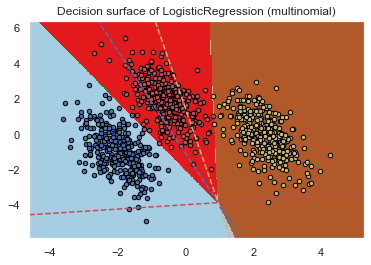

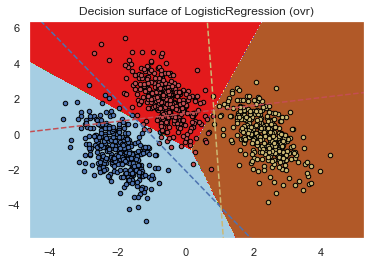

In [90]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

In [92]:
Z.shape

(615, 495)

In [96]:
clf.predict(np.c_[xx.ravel(), yy.ravel()]).shape

(304425,)

In [93]:
X.shape

(1000, 2)

In [40]:
model = getattr(model_logregCV, 'predict', model_logregCV)

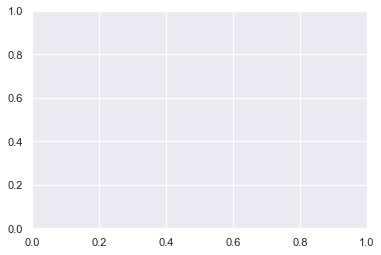

In [53]:
fig1, ax = plt.subplots()
nx=200
ny=200
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xx, yy = np.meshgrid(
np.linspace(xmin, xmax, nx),
np.linspace(ymin, ymax, ny))
X = np.c_[xx.flatten(), yy.flatten()]

In [102]:
model_logregCV.predict(np.array(mc_X_train).reshape(-1,7129)).shape

(600,)

In [104]:
np.c_[xx.ravel(), yy.ravel()]

array([[-4.61124176, -5.88341015],
       [-4.59124176, -5.88341015],
       [-4.57124176, -5.88341015],
       ...,
       [ 5.22875824,  6.39658985],
       [ 5.24875824,  6.39658985],
       [ 5.26875824,  6.39658985]])

ValueError: X has 2 features per sample; expecting 7129

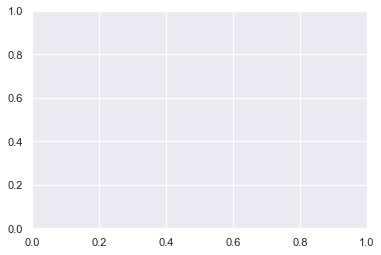

In [87]:
fig1, ax1 = plt.subplots()
overlay_decision_boundary(ax1, model_logregCV, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None)


In [68]:
# Your code here

fig2, ax2 = plt.subplots(1)

overlay_decision_boundary(ax2, model_logregCV_poly, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None)



In [70]:
# your code here


**4.5 Report and plot the CV scores for the two models and interpret.**

In [71]:
# your code here
logregCV.scores_)

In [72]:
# your code here


<div class='exercise'><b> Question 5: [10 pts] Including an 'abstain' option </b></div>

One of the reasons a hospital might be hesitant to use your cancer classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a specialist, which would incur additional cost.  How could one design a cancer classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**5.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from **Question 4**.  Note that this needs to be evaluated on the patients in the test set. 

**5.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

<hr>
### Solutions

**5.1 More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 4.  Note that this needs to be evaluated on the patients in the test set.**
**
...
**

*your answer here* 


In [73]:
# your code here


**5.2 Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.**

In [74]:
# your code here
